In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/signapoop/Desktop/fyp-graph-clustering'

In [26]:
%matplotlib inline
from timeit import default_timer as timer
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.sparse as sp
from sklearn import manifold
from sklearn.metrics import mean_squared_error

In [13]:
from core.DimReduction import DimReduction
from core.GraphConvNet2 import GraphConvNet2
from util.mnist_data_loader import get_train_set, get_test_set
from util.plot_embedding import plot_embedding, plot_embedding_subplot
from util.draw_random_subset import draw_random_subset

cuda not available


In [4]:
class graph_block(object):
    def __init__(self, X, y, labels, W, E_start, E_end):
        self.signal = X
        self.target = y
        self.labels = labels
        self.adj_matrix = W
        self.edge_to_starting_vertex = E_start
        self.edge_to_ending_vertex = E_end
        self.time_to_compute = 0
    
    def set_time_to_compute(self, timestamp):
        self.time_to_compute = timestamp

In [22]:
def get_graph_block(X, labels, reduction_method):
    # Affinity matrix
    embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
    W = embedder._get_affinity_matrix(X)
    W = sp.coo_matrix(W)
    
    if reduction_method == 'spectral':
        pass
    elif reduction_method == 'tsne':
        embedder = manifold.TSNE(n_components=2, init='pca', random_state=0)
    
    # Perform dimensionality reduction
    start = timer()
    y = embedder.fit_transform(X)
    end = timer()
    
    # Extract edge information
    nb_edges = W.nnz
    nb_vertices = W.shape[0]
    edge_to_starting_vertex = sp.coo_matrix((np.ones(nb_edges) ,(np.arange(nb_edges), W.row)),
                                            shape=(nb_edges, nb_vertices))
    edge_to_ending_vertex = sp.coo_matrix((np.ones(nb_edges) ,(np.arange(nb_edges), W.col)),
                                          shape=(nb_edges, nb_vertices))
    
    G = graph_block(X, y, labels, W, edge_to_starting_vertex, edge_to_ending_vertex)
    G.set_time_to_compute(end - start)
    return G

In [5]:
filename = 'results/embeddings2.pkl'
with open(filename, 'rb') as f:
    [G, y_pred] = pickle.load(f)

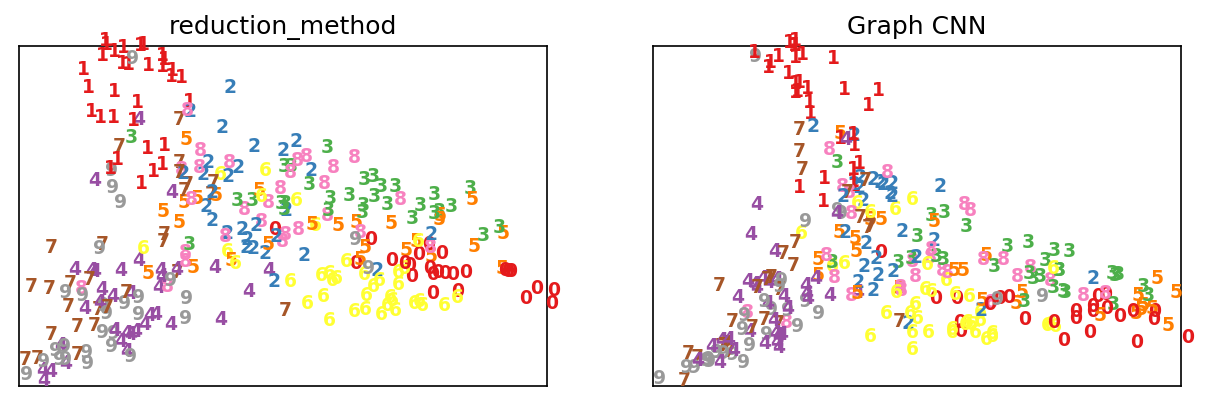

In [6]:
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), 'reduction_method')
plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), "Graph CNN")

In [7]:
loss = mean_squared_error(G.target, y_pred)
print("L2 loss = {}".format(loss))

L2 loss = 0.011860864630050861


In [8]:
W_coo = sp.coo_matrix(G.adj_matrix)
pairwise_loss_1 = mean_squared_error(G.target[W_coo.row,:], G.target[W_coo.col,:])
pairwise_loss_2 = mean_squared_error(y_pred[W_coo.row,:], y_pred[W_coo.col,:])
pairwise_loss = abs(pairwise_loss_1 - pairwise_loss_2)
print("Pairwise loss = {}".format(pairwise_loss))

Pairwise loss = 0.006918342510139064


In [9]:
filename = 'results/embeddings1.pkl'
with open(filename, 'rb') as f:
    [G, y_pred] = pickle.load(f)

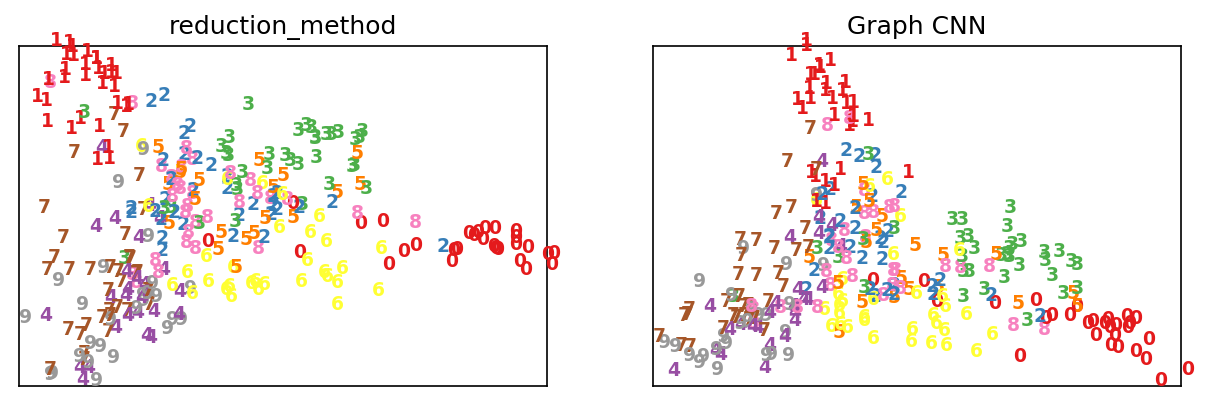

In [10]:
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), 'reduction_method')
plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), "Graph CNN")

In [11]:
loss = mean_squared_error(G.target, y_pred)
print("L2 loss = {}".format(loss))

L2 loss = 0.02327292481563495


In [12]:
W_coo = sp.coo_matrix(G.adj_matrix)
pairwise_loss_1 = mean_squared_error(G.target[W_coo.row,:], G.target[W_coo.col,:])
pairwise_loss_2 = mean_squared_error(y_pred[W_coo.row,:], y_pred[W_coo.col,:])
pairwise_loss = abs(pairwise_loss_1 - pairwise_loss_2)
print("Pairwise loss = {}".format(pairwise_loss))

Pairwise loss = 0.006487159795159361


In [14]:
task_parameters = {}
task_parameters['flag_task'] = 'clustering'
task_parameters['reduction_method'] = 'spectral'

net_parameters = {}
net_parameters['D'] = 784
net_parameters['n_components'] = 2
net_parameters['H'] = 50
net_parameters['L'] = 10

In [50]:
net = GraphConvNet2(net_parameters, task_parameters)


nb of hidden layers= 10
dim of layers (w/ embed dim)= [784, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]




In [51]:
filename = 'results/mnist_net.pkl'
checkpoint = torch.load(filename)
net.load_state_dict(checkpoint['state_dict'])

In [52]:
# Load Mnist dataset
data_dir = 'data/mnist'
test_data = get_test_set(data_dir)

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


L2 loss = 0.009788933323491376
Pairwise loss = 0.013118976120326864


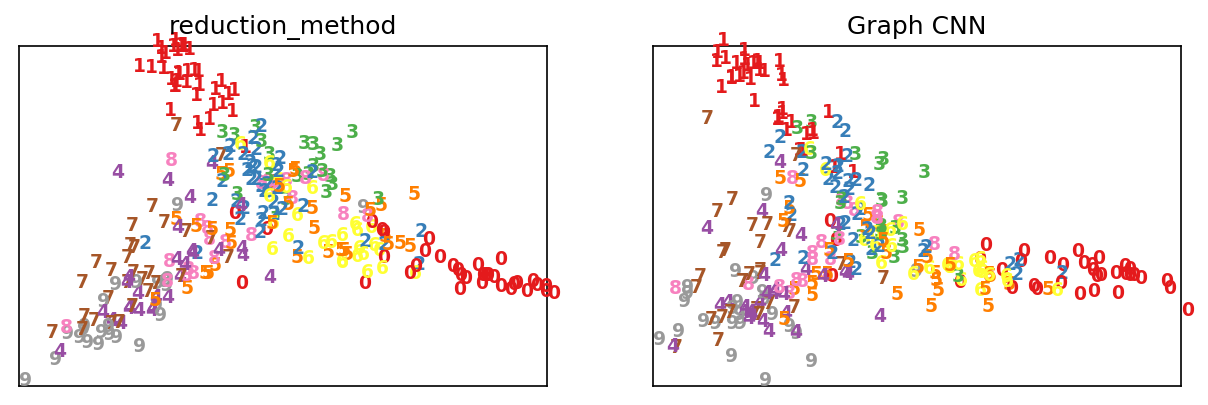

In [53]:
inputs, labels = draw_random_subset(test_data, num_samples=300)
inputs = inputs.view(inputs.shape[0],-1)
inputs = inputs.numpy()
G = get_graph_block(inputs, labels, 'spectral')
y_pred = net.forward(G)
y_pred = y_pred.detach().numpy()

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), 'reduction_method')
plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), "Graph CNN")

loss = mean_squared_error(G.target, y_pred)
print("L2 loss = {}".format(loss))

W_coo = sp.coo_matrix(G.adj_matrix)
pairwise_loss_1 = mean_squared_error(G.target[W_coo.row,:], G.target[W_coo.col,:])
pairwise_loss_2 = mean_squared_error(y_pred[W_coo.row,:], y_pred[W_coo.col,:])
pairwise_loss = abs(pairwise_loss_1 - pairwise_loss_2)
print("Pairwise loss = {}".format(pairwise_loss))

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


L2 loss = 0.1558201523836275
Pairwise loss = 0.04682693860337331
Pairwise loss 2 = 0.05039887148885988


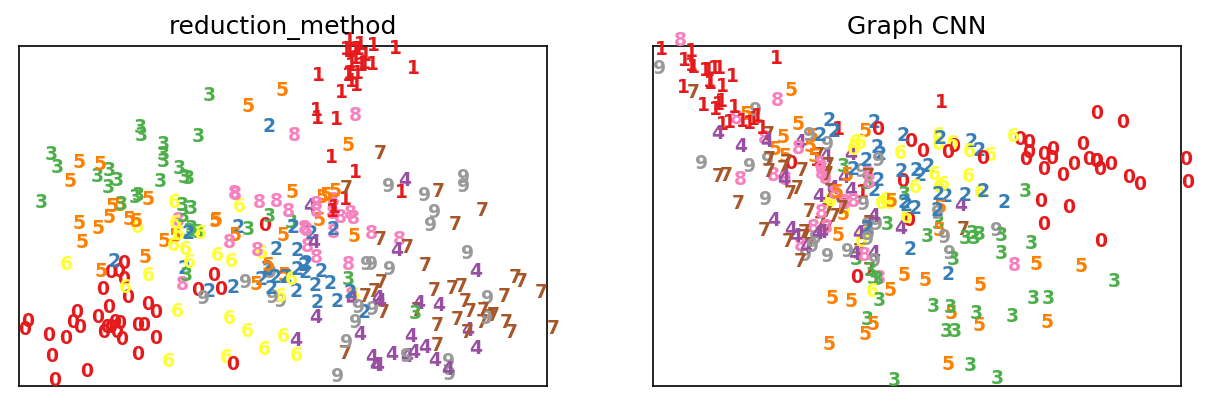

In [131]:
inputs, labels = draw_random_subset(test_data, num_samples=300)
inputs = inputs.view(inputs.shape[0],-1)
inputs = inputs.numpy()
G = get_graph_block(inputs, labels, 'spectral')
y_pred = net.forward(G)
y_pred = y_pred.detach().numpy()

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), 'reduction_method')
plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), "Graph CNN")

loss = mean_squared_error(G.target, y_pred)
print("L2 loss = {}".format(loss))

W_coo = sp.coo_matrix(G.adj_matrix)
pairwise_loss_1 = mean_squared_error(G.target[W_coo.row,:], G.target[W_coo.col,:])
pairwise_loss_2 = mean_squared_error(y_pred[W_coo.row,:], y_pred[W_coo.col,:])
pairwise_loss = abs(pairwise_loss_1 - pairwise_loss_2)
print("Pairwise loss = {}".format(pairwise_loss))

pairwise_loss_1 = l2_norm(G.target[W_coo.row,:] - G.target[W_coo.col,:])
pairwise_loss_2 = l2_norm(y_pred[W_coo.row,:] - y_pred[W_coo.col,:])
pairwise_loss = np.average(np.square(pairwise_loss_1 - pairwise_loss_2))
# pairwise_loss = abs(pairwise_loss_1 - pairwise_loss_2)
print("Pairwise loss 2 = {}".format(pairwise_loss))

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


L2 loss = 0.014812073631080488
Pairwise loss = 0.03293237130337359
Pairwise loss 2 = 0.022659445536448802


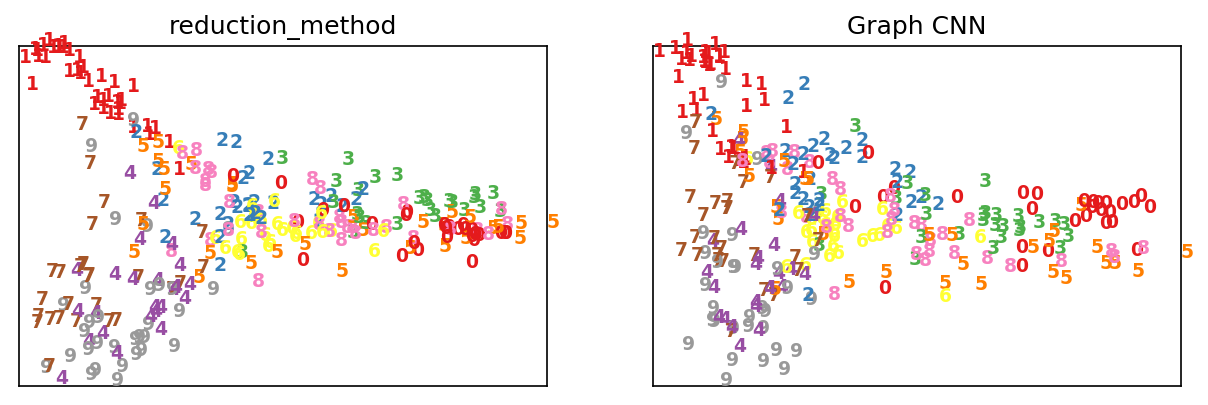

In [132]:
inputs, labels = draw_random_subset(test_data, num_samples=300)
inputs = inputs.view(inputs.shape[0],-1)
inputs = inputs.numpy()
G = get_graph_block(inputs, labels, 'spectral')
y_pred = net.forward(G)
y_pred = y_pred.detach().numpy()

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), 'reduction_method')
plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), "Graph CNN")

loss = mean_squared_error(G.target, y_pred)
print("L2 loss = {}".format(loss))

W_coo = sp.coo_matrix(G.adj_matrix)
pairwise_loss_1 = mean_squared_error(G.target[W_coo.row,:], G.target[W_coo.col,:])
pairwise_loss_2 = mean_squared_error(y_pred[W_coo.row,:], y_pred[W_coo.col,:])
pairwise_loss = abs(pairwise_loss_1 - pairwise_loss_2)
print("Pairwise loss = {}".format(pairwise_loss))

pairwise_loss_1 = l2_norm(G.target[W_coo.row,:] - G.target[W_coo.col,:])
pairwise_loss_2 = l2_norm(y_pred[W_coo.row,:] - y_pred[W_coo.col,:])
pairwise_loss = np.average(np.square(pairwise_loss_1 - pairwise_loss_2))
# pairwise_loss = abs(pairwise_loss_1 - pairwise_loss_2)
print("Pairwise loss 2 = {}".format(pairwise_loss))

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


L2 loss = 0.1847761320798441
Pairwise loss = 0.018476978150671064
Pairwise loss 2 = 0.01193961474639622


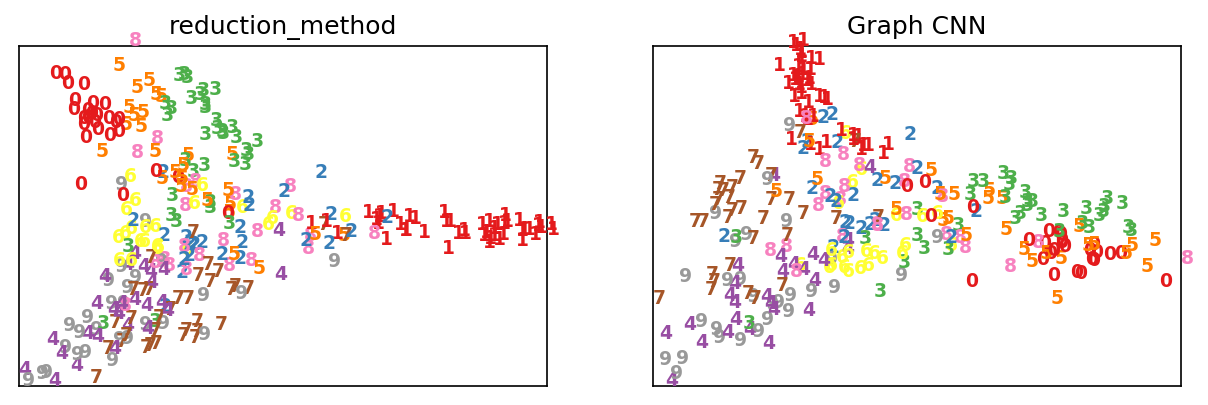

In [133]:
inputs, labels = draw_random_subset(test_data, num_samples=300)
inputs = inputs.view(inputs.shape[0],-1)
inputs = inputs.numpy()
G = get_graph_block(inputs, labels, 'spectral')
y_pred = net.forward(G)
y_pred = y_pred.detach().numpy()

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), 'reduction_method')
plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), "Graph CNN")

loss = mean_squared_error(G.target, y_pred)
print("L2 loss = {}".format(loss))

W_coo = sp.coo_matrix(G.adj_matrix)
pairwise_loss_1 = mean_squared_error(G.target[W_coo.row,:], G.target[W_coo.col,:])
pairwise_loss_2 = mean_squared_error(y_pred[W_coo.row,:], y_pred[W_coo.col,:])
pairwise_loss = abs(pairwise_loss_1 - pairwise_loss_2)
print("Pairwise loss = {}".format(pairwise_loss))

pairwise_loss_1 = l2_norm(G.target[W_coo.row,:] - G.target[W_coo.col,:])
pairwise_loss_2 = l2_norm(y_pred[W_coo.row,:] - y_pred[W_coo.col,:])
pairwise_loss = np.average(np.square(pairwise_loss_1 - pairwise_loss_2))
# pairwise_loss = abs(pairwise_loss_1 - pairwise_loss_2)
print("Pairwise loss 2 = {}".format(pairwise_loss))

In [128]:
def l2_norm(v):
    return np.sqrt(np.sum(np.square(v), axis=1, dtype=np.float64))

L2 loss = 0.011355023410568283
Pairwise loss = 0.018476923994083815
Pairwise loss 2 = 0.011939614773651968


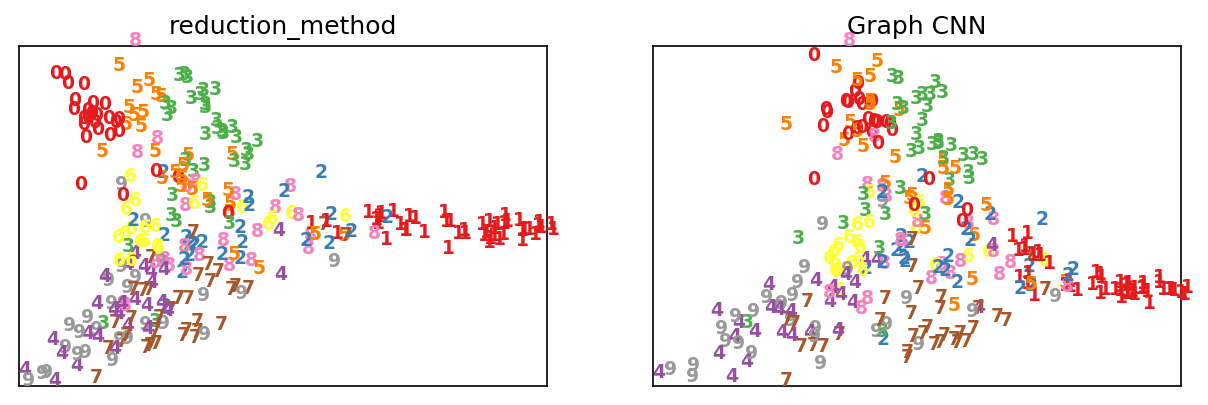

In [141]:
y_tmp = np.zeros(y_pred.shape)
y_tmp[:,0] = y_pred[:,1]
y_tmp[:,1] = y_pred[:,0]

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), 'reduction_method')
plot_embedding_subplot(axarr[1], y_tmp, G.labels.numpy(), "Graph CNN")

loss = mean_squared_error(G.target, y_tmp)
print("L2 loss = {}".format(loss))

W_coo = sp.coo_matrix(G.adj_matrix)
pairwise_loss_1 = mean_squared_error(G.target[W_coo.row,:], G.target[W_coo.col,:])
pairwise_loss_2 = mean_squared_error(y_tmp[W_coo.row,:], y_tmp[W_coo.col,:])
pairwise_loss = abs(pairwise_loss_1 - pairwise_loss_2)
print("Pairwise loss = {}".format(pairwise_loss))

pairwise_loss_1 = l2_norm(G.target[W_coo.row,:] - G.target[W_coo.col,:])
pairwise_loss_2 = l2_norm(y_tmp[W_coo.row,:] - y_tmp[W_coo.col,:])
pairwise_loss = np.average(np.square(pairwise_loss_1 - pairwise_loss_2))
# pairwise_loss = abs(pairwise_loss_1 - pairwise_loss_2)
print("Pairwise loss 2 = {}".format(pairwise_loss))

L2 loss = 0.18340866987865528
Pairwise loss = 0.018476978150671064
Pairwise loss 2 = 0.01193961474639622


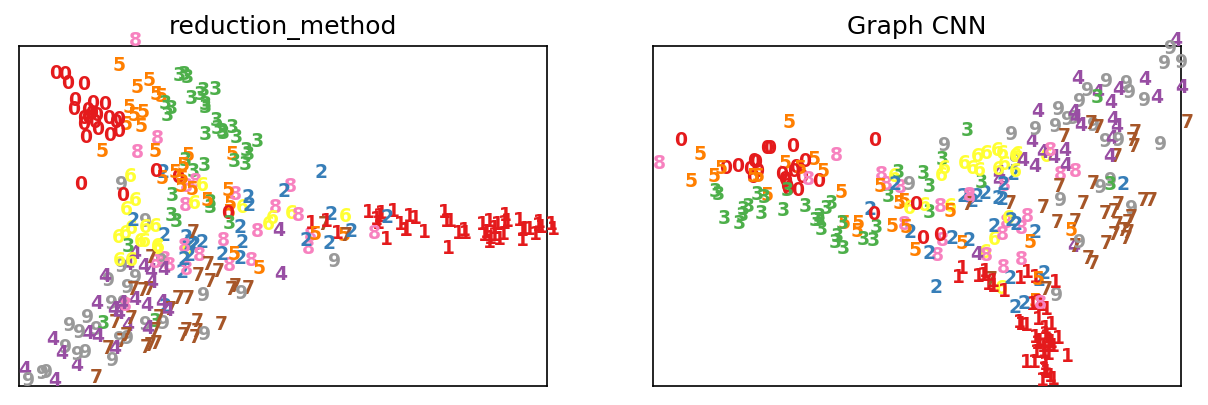

In [142]:
y_tmp = y_pred * -1

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), 'reduction_method')
plot_embedding_subplot(axarr[1], y_tmp, G.labels.numpy(), "Graph CNN")

loss = mean_squared_error(G.target, y_tmp)
print("L2 loss = {}".format(loss))

W_coo = sp.coo_matrix(G.adj_matrix)
pairwise_loss_1 = mean_squared_error(G.target[W_coo.row,:], G.target[W_coo.col,:])
pairwise_loss_2 = mean_squared_error(y_tmp[W_coo.row,:], y_tmp[W_coo.col,:])
pairwise_loss = abs(pairwise_loss_1 - pairwise_loss_2)
print("Pairwise loss = {}".format(pairwise_loss))

pairwise_loss_1 = l2_norm(G.target[W_coo.row,:] - G.target[W_coo.col,:])
pairwise_loss_2 = l2_norm(y_tmp[W_coo.row,:] - y_tmp[W_coo.col,:])
pairwise_loss = np.average(np.square(pairwise_loss_1 - pairwise_loss_2))
# pairwise_loss = abs(pairwise_loss_1 - pairwise_loss_2)
print("Pairwise loss 2 = {}".format(pairwise_loss))